In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
from tqdm import tqdm
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

os.chdir('/home/mattho/git/ltu-cmass/notebooks')

9.539942 nan
0.009763996 317.983
5.2189426 264.03848
8.20555 nan


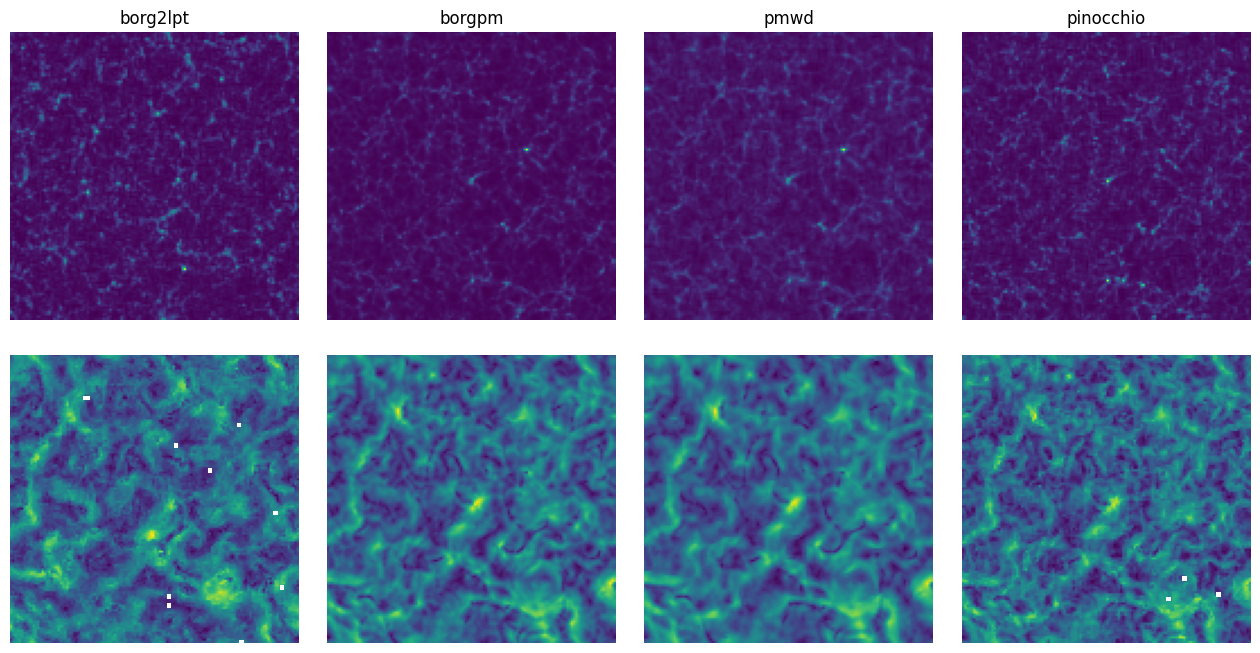

In [2]:
# temp
mlist = ['borg2lpt', 'borgpm', 'pmwd', 'pinocchio']

f, axs = plt.subplots(
    2,len(mlist), figsize=(4*len(mlist),8), 
    gridspec_kw=dict(hspace=0.1, wspace=0.1)
)

for i, m in enumerate(mlist):
    path = f"/home/mattho/git/ltu-cmass/data/test/{m}/L1000-N128/100"

    rho = np.load(join(path, 'rho.npy'))
    fvel = np.load(join(path, 'fvel.npy'))
    print(rho.std(), fvel.std())

    ax = axs[0,i]
    ax.imshow(rho[0])
    ax.axis('off')
    ax.set_title(m)

    ax = axs[1,i]
    ax.imshow(np.linalg.norm(fvel[0], axis=-1))
    ax.axis('off')


## Suite

In [18]:
from collections import Counter
suitepath = '/home/mattho/git/ltu-cmass/data/charm_1gpch_z0.5/borgpm/L1000-N128/'

c = Counter()
for r in tqdm(os.listdir(suitepath)):
    for k in os.listdir(join(suitepath, r)):
        c[k] += 1
c

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:00<00:00, 7258.60it/s]


Counter({'rho.npy': 2000,
         'fvel.npy': 2000,
         'rho_z50.npy': 2000,
         'config.yaml': 2000,
         'halo_pos.npy': 2000,
         'halo_vel.npy': 2000,
         'halo_mass.npy': 2000,
         'halo_cuboid_pos.npy': 2000,
         'halo_cuboid_vel.npy': 2000,
         'hod': 2000,
         'obs': 1999,
         'Pk': 1999})

In [4]:
cosmofile = '../params/latin_hypercube_params.txt'
cosmos = pd.read_csv(cosmofile, sep=' ', header=None).values
cosmos

array([[0.1755 , 0.06681, 0.7737 , 0.8849 , 0.6641 ],
       [0.2139 , 0.05557, 0.8599 , 0.9785 , 0.8619 ],
       [0.1867 , 0.04503, 0.6189 , 0.8307 , 0.7187 ],
       ...,
       [0.4017 , 0.04425, 0.8509 , 0.8251 , 0.7833 ],
       [0.2953 , 0.04701, 0.8017 , 0.8193 , 0.6627 ],
       [0.3175 , 0.049  , 0.6711 , 0.9624 , 0.834  ]])

In [5]:
# Load Pks
pks = np.zeros((len(cosmos), 399))
for r in tqdm(os.listdir(suitepath)):
    try:
        pk = np.load(join(suitepath, r, 'Pk', 'Pk0.npz'))
    except FileNotFoundError:
        continue
    k_gal = pk['k_gal']
    p0 = pk['p0k_gal']
    pks[int(r)] = p0

100%|██████████| 2000/2000 [00:02<00:00, 890.66it/s]


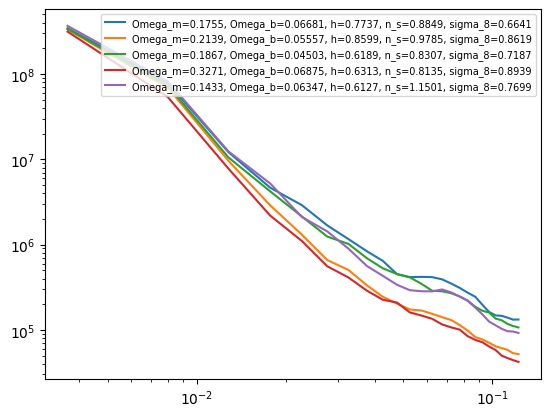

In [6]:
plt.loglog()

for i in range(5):
    lstr = f"Omega_m={cosmos[i,0]}, Omega_b={cosmos[i,1]}, "
    lstr += f"h={cosmos[i,2]}, n_s={cosmos[i,3]}, sigma_8={cosmos[i,4]}"
    plt.plot(k_gal, pks[i], label=lstr)
plt.legend(fontsize=7)

## Inference

In [7]:
mask = np.all(pks==0, axis=1)
pks = pks[~mask]
cosmos = cosmos[~mask]

x = np.log10(pks[:2000,:25])
theta = cosmos[:2000]

In [12]:
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
device='cpu'

In [13]:
loader = NumpyLoader(x=x, theta=theta)

# define a prior
prior = ili.utils.Uniform(
    low=theta.min(axis=0),
    high=theta.max(axis=0),
    device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_lampe(model='nsf', hidden_features=50, num_transforms=5),
    ili.utils.load_nde_lampe(model='gf', hidden_features=50, num_transforms=5)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 1e-4
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='lampe',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args
)

In [14]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.
244 epochs [02:47,  1.46 epochs/s, loss=-13.1, loss_val=-12]  
INFO:root:Training model 2 / 2.
271 epochs [02:30,  1.81 epochs/s, loss=-12.4, loss_val=-11.6]
INFO:root:It took 317.7501962184906 seconds to train models.


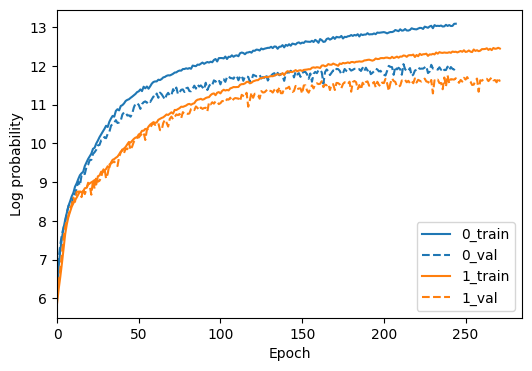

In [15]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = [f"C{i}" for i in range(len(summaries))]
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

INFO:root:Sampling models with tensor([572., 428.]) samples each.
Drawing 572 posterior samples: 1109it [00:00, 6174.46it/s]                        
Drawing 428 posterior samples: 778it [00:00, 14247.72it/s]            


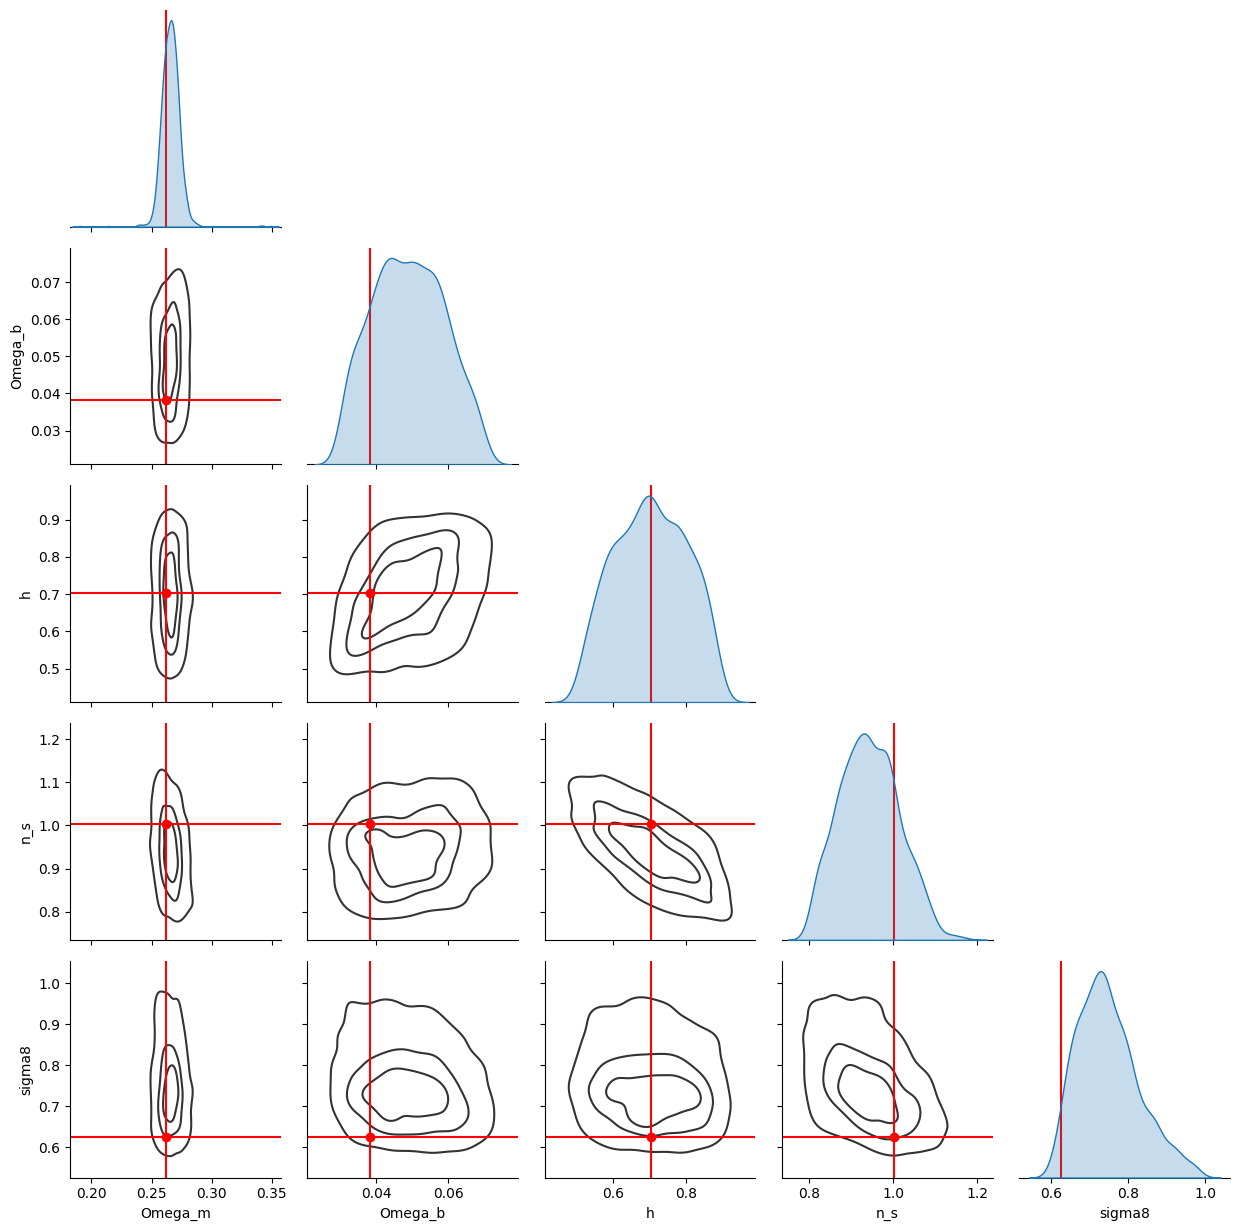

In [16]:
# choose a random input
seed_in = 49
np.random.seed(seed_in)
ind = np.random.randint(len(theta))

# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8']
    # labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_fid=theta[ind]
)

100%|██████████| 1999/1999 [06:07<00:00,  5.44it/s] 
INFO:root:Mean logprob: 1.2509e+01Median logprob: 1.2591e+01
100%|██████████| 100/100 [00:13<00:00,  7.24it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


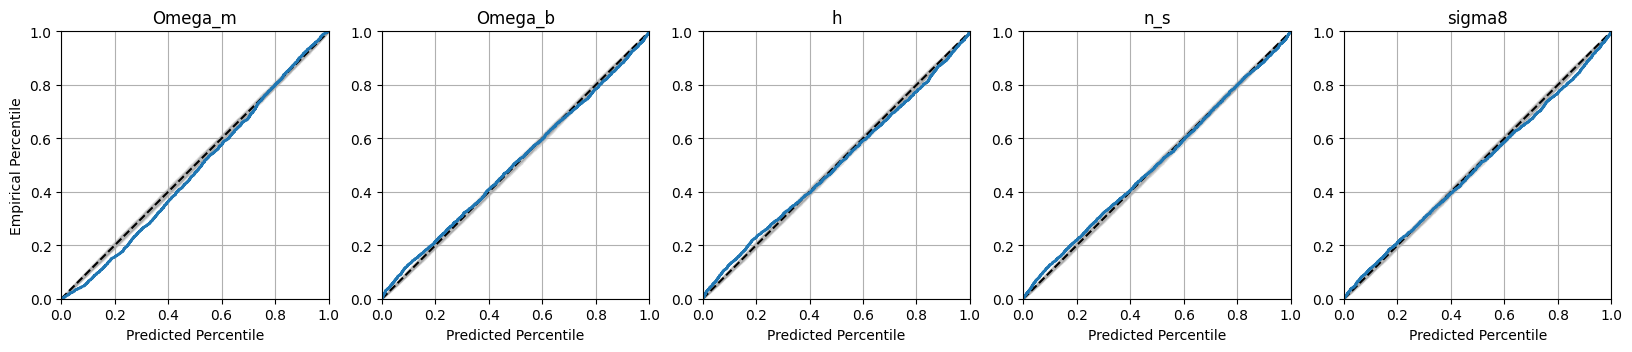

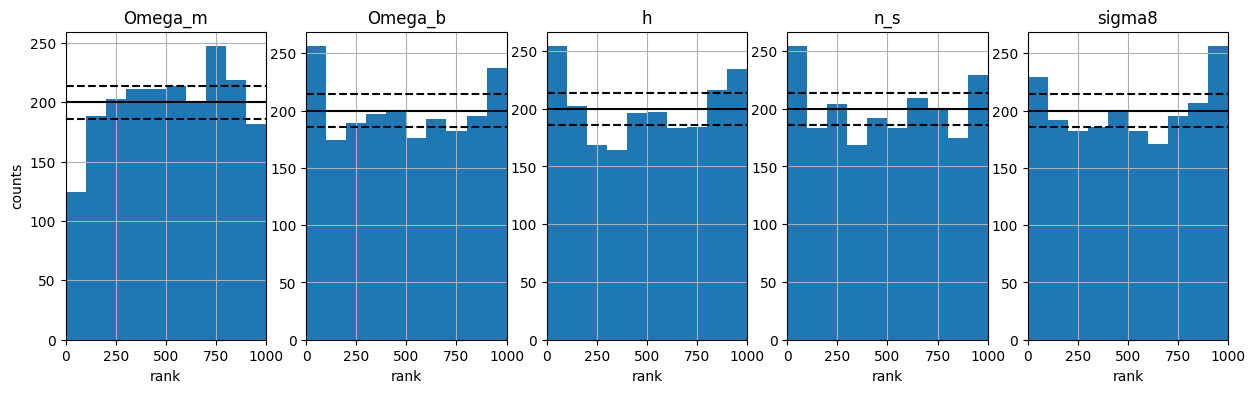

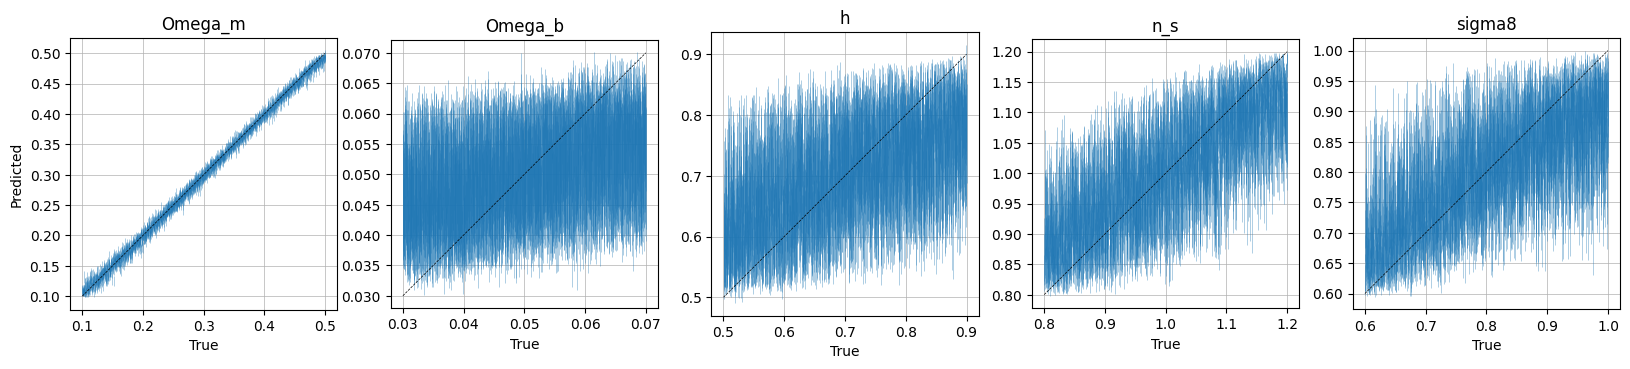

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


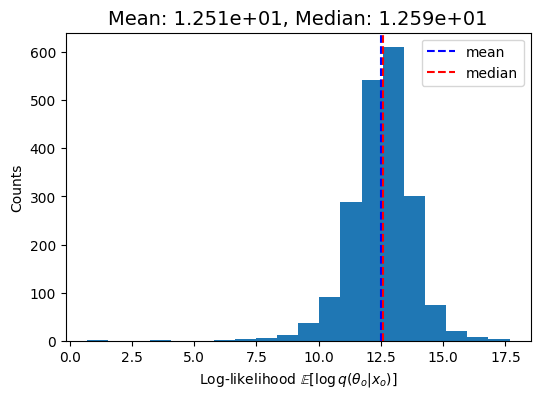

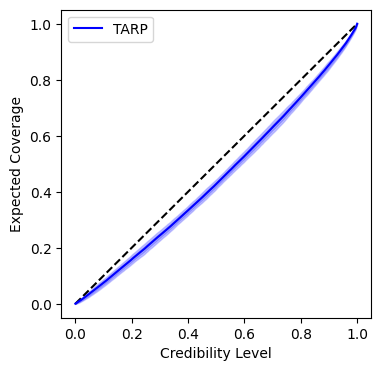

In [17]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma8'],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=theta
)

## Compare suite on every level

In [43]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
from tqdm import tqdm
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import MAS_library as MASL
import Pk_library as PKL
import redshift_space_library as RSL
from omegaconf import OmegaConf

os.chdir('/home/mattho/git/ltu-cmass/matts_tests')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import sys
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


def Pk3D(x, L=1000, MAS='None', axis=0, threads=16):
    # handle multiple x's
    if len(x.shape) == 4:
        results = [Pk3D(xi, L, MAS, axis, threads) for xi in x]
        k, Pk = list(zip(*results))
        return np.array(k), np.array(Pk)

    Pk = PKL.Pk(x.astype(np.float32),
                L, axis, MAS, threads, verbose=0)
    return Pk.k1D, Pk.Pk1D

In [39]:
from collections import Counter
suitepath = '/home/mattho/git/ltu-cmass/data/charm_1gpch_z0.5/borgpm/L1000-N128/'

c = Counter()
for r in tqdm(os.listdir(suitepath)):
    for k in os.listdir(join(suitepath, r)):
        c[k] += 1
c

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:00<00:00, 7526.90it/s]


Counter({'rho.npy': 2000,
         'fvel.npy': 2000,
         'rho_z50.npy': 2000,
         'config.yaml': 2000,
         'halo_pos.npy': 2000,
         'halo_vel.npy': 2000,
         'halo_mass.npy': 2000,
         'halo_cuboid_pos.npy': 2000,
         'halo_cuboid_vel.npy': 2000,
         'hod': 2000,
         'obs': 1999,
         'Pk': 1999})

In [40]:
cosmofile = '../params/latin_hypercube_params.txt'
cosmos = pd.read_csv(cosmofile, sep=' ', header=None).values

In [41]:
# Measure rho power spectra
rho_pk = []
for p in tqdm(os.listdir(suitepath)):
    rho = np.load(join(suitepath, p, 'rho.npy'))
    cfg = OmegaConf.load(join(suitepath, p, 'config.yaml'))
    N = cfg.nbody.N
    L = cfg.nbody.L
    
    k, _Pk = Pk3D(rho, L=L, MAS='CIC', threads=16)
    rho_pk.append(_Pk)

100%|██████████| 2000/2000 [05:55<00:00,  5.62it/s]


In [42]:
# Measure halo power spectra
MAS = 'NGP'
halo_pk = []
for p in tqdm(os.listdir(suitepath)):
    hpos = np.load(join(suitepath, p, 'halo_pos.npy'))
    cfg = OmegaConf.load(join(suitepath, p, 'config.yaml'))
    N = cfg.nbody.N
    L = cfg.nbody.L

    delta = np.empty((N,N,N), dtype=np.float32)
    MASL.MA(hpos.astype(np.float32), delta, L, MAS=MAS, verbose=0)
    delta /= delta.mean()
    delta -= 1
    
    k, _Pk = Pk3D(delta, L=L, MAS=MAS, threads=16)
    halo_pk.append(_Pk)

100%|██████████| 2000/2000 [04:31<00:00,  7.36it/s]


In [44]:
# Measure halo power spectra in redshift space
MAS = 'NGP'
haloz_pk = []
for p in tqdm(os.listdir(suitepath)):
    hpos = np.load(join(suitepath, p, 'halo_pos.npy'))
    hvel = np.load(join(suitepath, p, 'halo_vel.npy'))
    cfg = OmegaConf.load(join(suitepath, p, 'config.yaml'))
    N = cfg.nbody.N
    L = cfg.nbody.L
    h = cfg.nbody.cosmo[2]

    RSL.pos_redshift_space(hpos, hvel, L, Hubble=h*100, redshift=0.5, axis=0)

    delta = np.empty((N,N,N), dtype=np.float32)
    MASL.MA(hpos.astype(np.float32), delta, L, MAS=MAS, verbose=0)
    delta /= delta.mean()
    delta -= 1
    
    k, _Pk = Pk3D(delta, L=L, MAS=MAS, threads=16)
    haloz_pk.append(_Pk)

 60%|██████    | 1202/2000 [02:56<01:55,  6.88it/s]/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/tmp/ipykernel_86092/3656701308.py:16: RuntimeWarning: invalid value encountered in divide
  delta /= delta.mean()
100%|██████████| 2000/2000 [04:41<00:00,  7.11it/s]


In [47]:
# Measure galaxy power spectra
hod = 0
MAS = 'NGP'
gal_pk = []
for p in tqdm(os.listdir(suitepath)):
    gpos = np.load(join(suitepath, p, 'hod', f'hod{hod}_pos.npy'))
    cfg = OmegaConf.load(join(suitepath, p, 'config.yaml'))
    N = cfg.nbody.N
    L = cfg.nbody.L

    delta = np.empty((N,N,N), dtype=np.float32)
    MASL.MA(hpos.astype(np.float32), delta, L, MAS=MAS, verbose=0)
    delta /= delta.mean()
    delta -= 1
    
    k, _Pk = Pk3D(delta, L=L, MAS=MAS, threads=16)
    gal_pk.append(_Pk)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [06:09<00:00,  5.41it/s]


In [51]:
# Measure galaxy power spectra in redshift space
hod = 0
MAS = 'NGP'
galz_pk = []
for p in tqdm(os.listdir(suitepath)):
    gpos = np.load(join(suitepath, p, 'hod', f'hod{hod}_pos.npy')).copy(order='C')
    gvel = np.load(join(suitepath, p, 'hod', f'hod{hod}_vel.npy')).copy(order='C')
    cfg = OmegaConf.load(join(suitepath, p, 'config.yaml'))
    N = cfg.nbody.N
    L = cfg.nbody.L
    h = cfg.nbody.cosmo[2]

    RSL.pos_redshift_space(gpos, gvel, L, Hubble=h*100, redshift=0.5, axis=0)

    delta = np.empty((N,N,N), dtype=np.float32)
    MASL.MA(gpos.astype(np.float32), delta, L, MAS=MAS, verbose=0)
    delta /= delta.mean()
    delta -= 1
    
    k, _Pk = Pk3D(delta, L=L, MAS=MAS, threads=16)
    galz_pk.append(_Pk)

100%|██████████| 2000/2000 [06:41<00:00,  4.98it/s]


In [69]:
# Load galaxy survey power spectra
survey_pk = []
for p in tqdm(os.listdir(suitepath)):
    try:
        _Pk = np.load(join(suitepath, p, 'Pk', 'Pk0.npz'))
    except FileNotFoundError:
        print(f"Skipping {p}. TODO: fix")
        survey_pk.append(p0)
        continue
    k_sur = _Pk['k_gal']
    p0 = _Pk['p0k_gal']
    survey_pk.append(p0)

 50%|████▉     | 990/2000 [00:00<00:00, 1545.28it/s]

Skipping 713. TODO: fix


100%|██████████| 2000/2000 [00:01<00:00, 1473.55it/s]


In [70]:
rho_pk = np.stack(rho_pk, axis=0)
halo_pk = np.stack(halo_pk, axis=0)
haloz_pk = np.stack(haloz_pk, axis=0)
gal_pk = np.stack(gal_pk, axis=0)
galz_pk = np.stack(galz_pk, axis=0)
survey_pk = np.stack(survey_pk, axis=0)

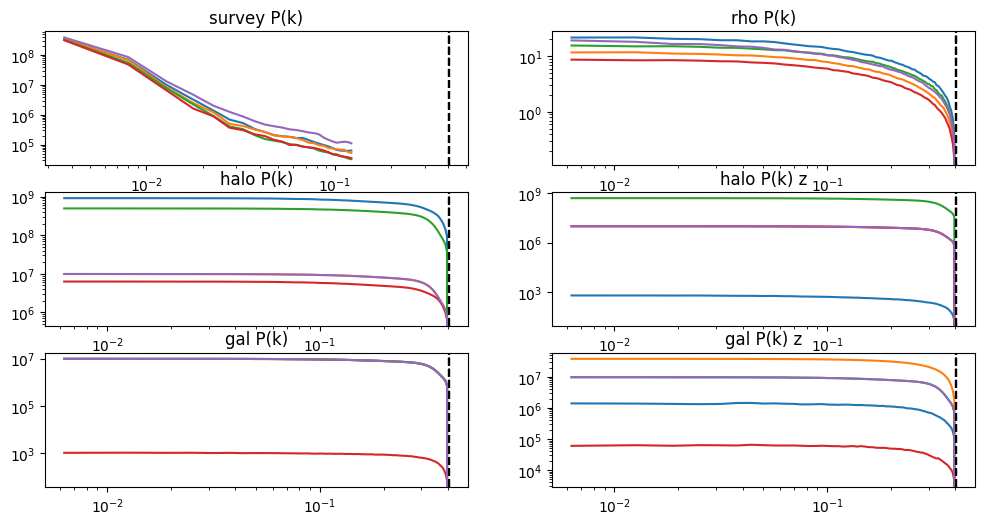

In [83]:
k_nyq = np.pi * N / L
Nsamp = 5

fig = plt.figure(figsize=(12,8))
gs = fig.add_gridspec(4,2)

axs = [fig.add_subplot(gs[i]) for i in range(6)]

for i, ind in enumerate(np.random.choice(len(rho_pk), Nsamp, replace=False)):
    label = f"$\Omega_m={cosmos[ind,0]}, \Omega_b={cosmos[ind,1]}, $\n"
    label += f"$h={cosmos[ind,2]}, n_s={cosmos[ind,3]}, sigma_8={cosmos[ind,4]}$"

    # survey Pk
    ax = axs[0]
    ax.loglog(k_sur, survey_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('survey P(k)')

    # rho Pk
    ax = axs[1]
    ax.loglog(k, rho_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('rho P(k)')

    # halo Pk
    ax = axs[2]
    ax.loglog(k, halo_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('halo P(k)')

    # haloz Pk
    ax = axs[3]
    ax.loglog(k, haloz_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('halo P(k) z')

    # gal Pk
    ax = axs[4]
    ax.loglog(k, gal_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('gal P(k)')

    # galz Pk
    ax = axs[5]
    ax.loglog(k, galz_pk[ind], label=label)
    ax.axvline(k_nyq, ls='--', c='k')
    ax.set_title('gal P(k) z')
    h, l = ax.get_legend_handles_labels()

ax = f.add_subplot(gs[7:])
ax.legend(h, l, fontsize=7);

In [84]:
gs.shape

AttributeError: 'GridSpec' object has no attribute 'shape'